# 推理引擎ONNX Runtime部署-预测单张图像

使用推理引擎 ONNX Runtime，读取 onnx 格式的模型文件，对单张图像文件进行预测。

同济子豪兄 https://space.bilibili.com/1900783

2022-8-22

## 应用场景

以下代码在需要部署的硬件上运行

只需把`onnx`模型文件发到部署硬件上，并安装 ONNX Runtime 环境，用几行代码就可以运行模型了。

## 导入工具包

In [14]:
import onnxruntime
import numpy as np
import torch

## 载入 onnx 模型，获取 ONNX Runtime 推理器

In [15]:
ort_session = onnxruntime.InferenceSession('fruit30_resnet18.onnx')

## 构造输入，获取输出结果

In [16]:
x = torch.randn(1, 3, 256, 256).numpy()

In [17]:
x.shape

(1, 3, 256, 256)

In [18]:
# onnx runtime 输入
ort_inputs = {'input': x}

# onnx runtime 输出
ort_output = ort_session.run(['output'], ort_inputs)[0]

注意，输入输出张量的名称需要和 torch.onnx.export 中设置的输入输出名对应

In [19]:
ort_output.shape

(1, 30)

In [20]:
# ort_output

## 预处理

In [21]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

### 载入测试图像

In [22]:
img_path = 'test_img/watermelon1.jpg'

In [23]:
# 用 pillow 载入
from PIL import Image
img_pil = Image.open(img_path)

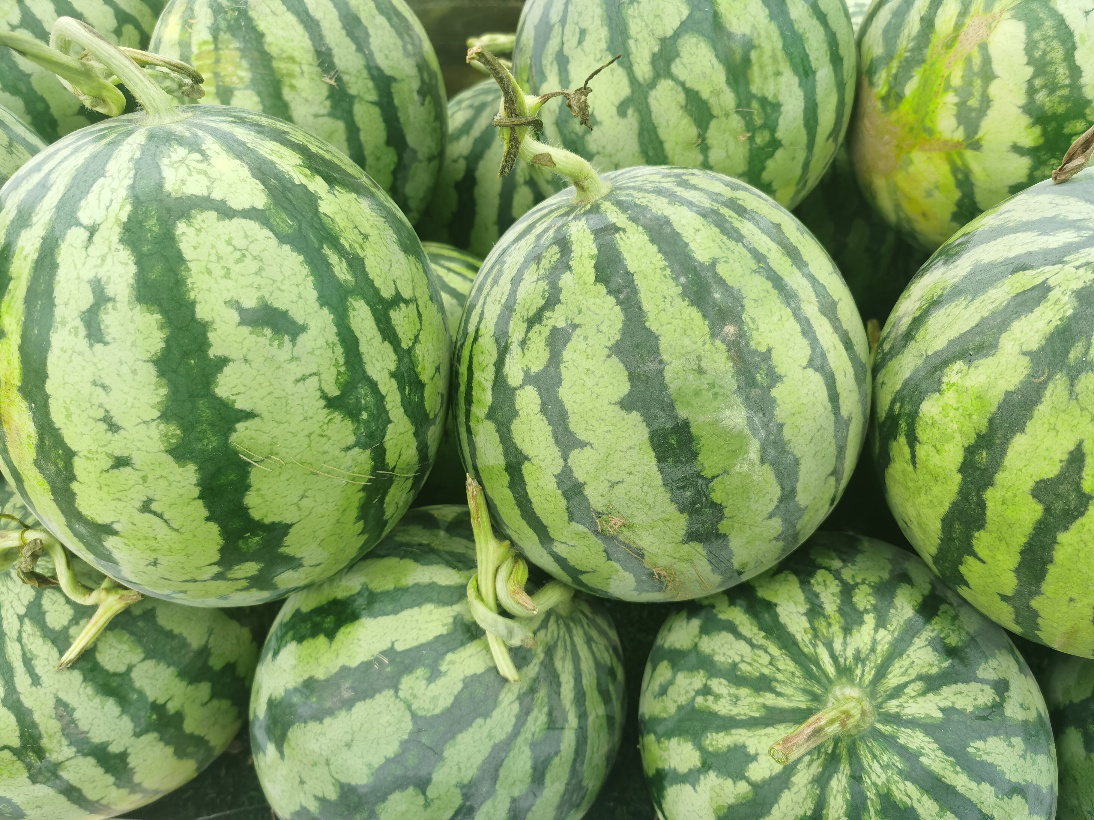

In [24]:
img_pil

## 运行预处理

In [25]:
input_img = test_transform(img_pil)

In [26]:
input_img.shape

torch.Size([3, 256, 256])

In [27]:
input_tensor = input_img.unsqueeze(0).numpy()

In [28]:
input_tensor.shape

(1, 3, 256, 256)

## ONNX Runtime预测

In [29]:
# ONNX Runtime 输入
ort_inputs = {'input': input_tensor}

In [30]:
# ONNX Runtime 输出
pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

In [31]:
pred_logits.shape

torch.Size([1, 30])

In [32]:
import torch.nn.functional as F
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [33]:
pred_softmax.shape

torch.Size([1, 30])

## 解析预测结果

### 载入类别和对应 ID

In [38]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [39]:
idx_to_labels

{0: '哈密瓜',
 1: '圣女果',
 2: '山竹',
 3: '杨梅',
 4: '柚子',
 5: '柠檬',
 6: '桂圆',
 7: '梨',
 8: '椰子',
 9: '榴莲',
 10: '火龙果',
 11: '猕猴桃',
 12: '石榴',
 13: '砂糖橘',
 14: '胡萝卜',
 15: '脐橙',
 16: '芒果',
 17: '苦瓜',
 18: '苹果-红',
 19: '苹果-青',
 20: '草莓',
 21: '荔枝',
 22: '菠萝',
 23: '葡萄-白',
 24: '葡萄-红',
 25: '西瓜',
 26: '西红柿',
 27: '车厘子',
 28: '香蕉',
 29: '黄瓜'}

### 设置matplotlib中文字体

In [40]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [41]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [42]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


--2022-08-22 20:07:27--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/environment/minico 100%[===================>]   9.58M  15.9MB/s    in 0.6s    

2022-08-22 20:07:28 (15.9 MB/s) - ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



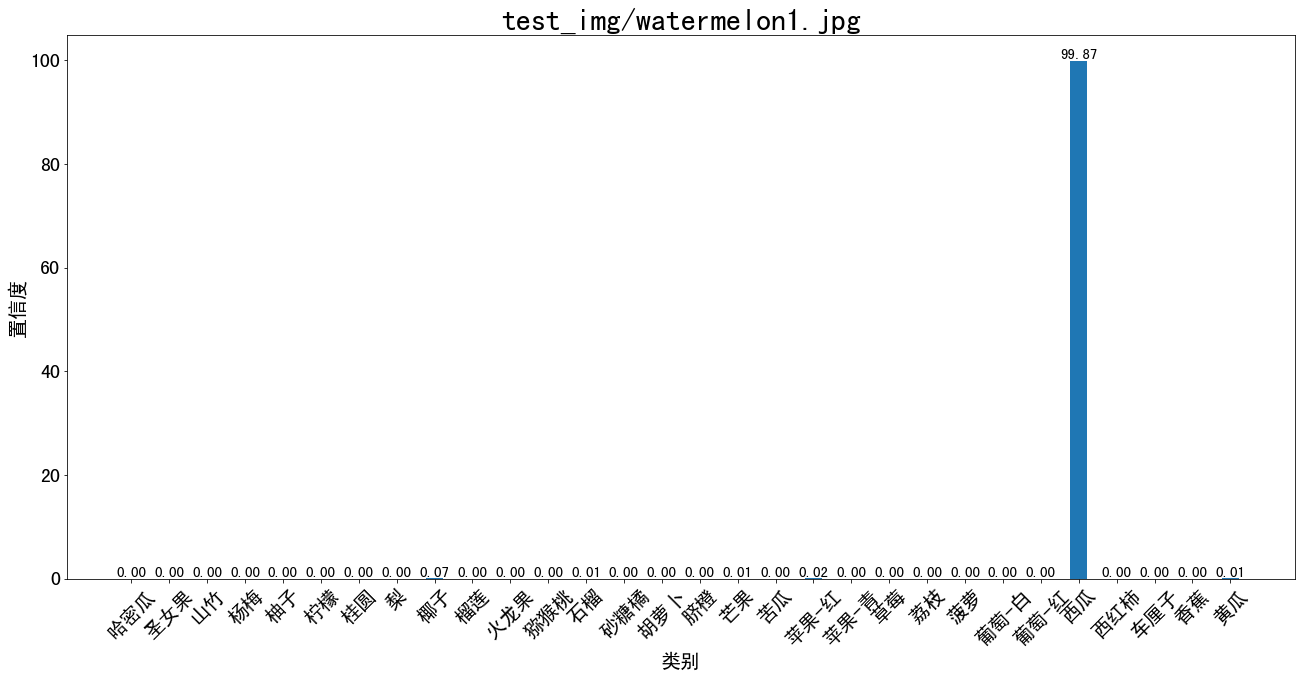

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(22, 10))

x = idx_to_labels.values()
y = pred_softmax.cpu().detach().numpy()[0] * 100
width = 0.45 # 柱状图宽度

ax = plt.bar(x, y, width)

plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
plt.tick_params(labelsize=20) # 设置坐标文字大小

plt.title(img_path, fontsize=30)
plt.xticks(rotation=45) # 横轴文字旋转
plt.xlabel('类别', fontsize=20)
plt.ylabel('置信度', fontsize=20)
plt.show()

后续步骤：在图像上写中文预测结果

同原生pytorch对单张图像、视频文件、摄像头实时画面预测：https://www.bilibili.com/video/BV12d4y1P7xz